In [1]:
import numpy as np
import thinkdsp
import pyaudio
import thinkplot
from convolution import fft_convolve
import matplotlib.pyplot as plt
import audioop
import struct
from array import array
import wave as wv
from IPython.display import Audio
import pygame




%matplotlib inline

In [200]:
sample = 1.0/200 #samples per second to test against
pitch = 440
sig_type = 'saw'
filename =  'flesh_wound.wav'

In [202]:
def get_samples_from_mic(sample_rate = 8000, threshold = 1000, chunk_size = 1000):
    # initialize pyaudio object
    p = pyaudio.PyAudio()
    stream = p.open(format=pyaudio.paInt16, channels=1, rate=sample_rate,
            input=True, output=True,
            frames_per_buffer=chunk_size)

    
    def is_silent(snd_data, th):
    #"Returns 'True' if below the 'silent' threshold"
        return max(snd_data) < th


# initialize an array to store the data
    data_vec = array('h')
    
# wait until we hear something
    while 1:
        # read a chunk of samples from the mic
        data = stream.read(chunk_size)
        # convert the data into an array of int16s
        snd_data = array('h', data)
        # if no longer silent break out of detection loop
        if not is_silent(snd_data, threshold):
            break

# append the sound data from the previous chunk into the array             
    data_vec.extend(snd_data)
    
# collect samples until we get a silent block
    while 1:
        # read a chunk of data
        data = stream.read(chunk_size)
        snd_data = array('h', data)
        # stick the chunk of samples at the end of the vector that stores
        # the samples
        data_vec.extend(snd_data)     
        # if silent break out of loop
        if is_silent(snd_data, threshold):
            break
            
# convert to a numpy array   
# we don't use a numpy array directly because it's slower than
# array 
    x = np.frombuffer(data_vec, dtype= np.dtype('int16'))    
    
# close the pyaudio stream     
    stream.stop_stream()
    stream.close()
    p.terminate()

# return the data samples    
    return x  

In [203]:
chunk = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 41000
RECORD_SECONDS = 5

p = pyaudio.PyAudio()

stream = p.open(format = FORMAT,
                channels = CHANNELS,
                rate = RATE,
                input = True,
                output = True,
                frames_per_buffer = chunk)

print "* recording"

data = get_samples_from_mic(RATE,300,chunk)



* recording


In [204]:
DUR = len(data)/float(RATE)
audio = Audio(data=data, rate=RATE)
audio

In [205]:
DUR

0.7242926829268292

In [206]:
len(np.fft.fft(data))

29696

In [207]:
v_wave = thinkdsp.read_wave(filename)
print(v_wave.duration)
print(v_wave.framerate)
v_wave.normalize()
#wave.apodize()
v_wave.make_audio()

6.15328798186
11025


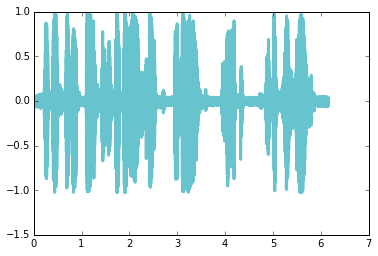

In [208]:
v_wave.plot()

In [209]:
vSeg = []
for s in np.arange(0,DUR,sample):
    start = round(s*RATE)
    stop = start + round(sample*RATE)
    vSeg.append(data[start: stop])

11025


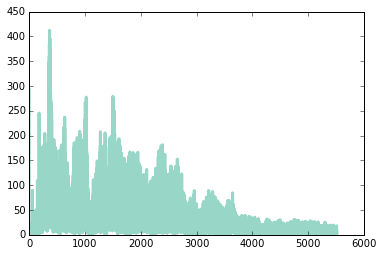

In [210]:

v_spectrum = v_wave.make_spectrum()
print(v_spectrum.framerate)
v_spectrum.plot()


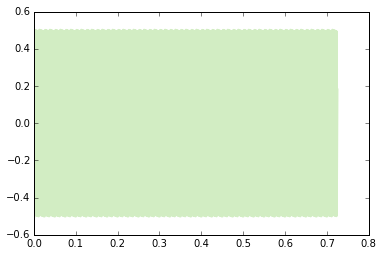

In [211]:
if sig_type == 'saw':
    sig = thinkdsp.SawtoothSignal(freq=pitch, amp=1, offset=0)
elif sig_type == 'sin':
    sig = thinkdsp.SinSignal(freq=pitch, amp=1, offset=0)
elif sig_type == 'cos':
    sig = thinkdsp.CosSignal(freq=pitch, amp=1, offset=0)
elif sig_type == 'tri':
    sig = thinkdsp.TriangleSignal(freq=pitch, amp=0.5, offset=0)
elif sig_type == 'sqr':
    sig = thinkdsp.SquareSignal(freq=pitch, amp=0.5, offset=0)
elif sig_type == 'par':
    sig = thinkdsp.ParabolicSignal(freq=pitch, amp=0.5, offset=0)
sig = thinkdsp.SawtoothSignal(freq=pitch, amp=0.5, offset=0)
wave=sig.make_wave(framerate = RATE, duration = DUR)
wave.plot()
wave.make_audio()

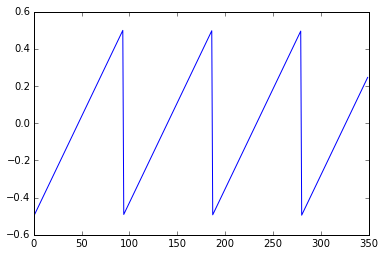

In [212]:
plt.plot(range(len(wave.ys[0:350])), wave.ys[0:350])

In [213]:
Seg = []
for s in np.arange(0,DUR,sample):
    Seg.append(wave.segment(s,sample))

41000


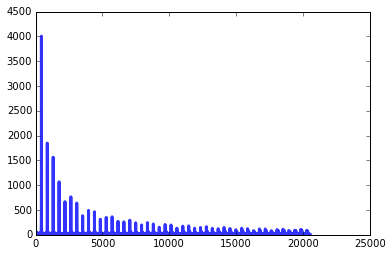

In [214]:
spec = wave.make_spectrum()
print(spec.framerate)
spec.plot()


In [215]:
#print(np.fft.fft(vSeg[0]))
#print(np.fft.fft(Seg[0].ys))
x = np.fft.rfft(vSeg[100])
y = np.fft.rfft(Seg[100].ys)
x = x/5000
len(y)

103

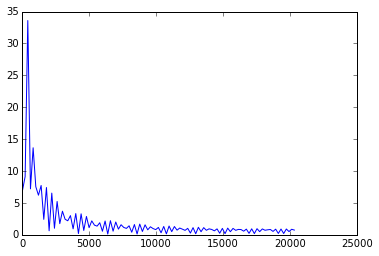

In [216]:
n = len(y)
if n%2 == 0:
    max_freq = RATE/2.0
else:
    max_freq = RATE/2.0 * (n-1) / n
xs = np.linspace(0, max_freq, n)
ys = np.absolute(y)
plt.plot(xs, ys)

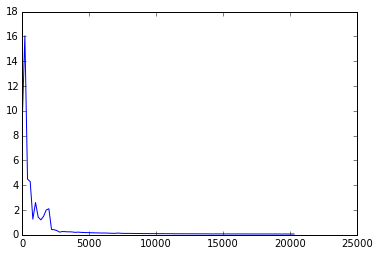

In [217]:
n = len(x)
if n%2 == 0:
    max_freq = RATE/2.0
else:
    max_freq = RATE/2.0 * (n-1) / n
xs = np.linspace(0, max_freq, n)
ys = np.absolute(x)
plt.plot(xs, ys)

In [218]:
frames= RATE
for i in range(len(vSeg)):
    x = np.fft.rfft(vSeg[i])
    y = np.fft.rfft(Seg[i].ys)
    hs =(np.absolute(x/5000)*np.absolute(y))*(np.cos(np.angle(y))+(np.sin(np.angle(y))*1j))
    if i == 0:
        voc_s =(np.fft.irfft(hs))
        
    elif i==100 :
        v1 = hs
    else:
         voc_s = np.concatenate((voc_s, np.fft.irfft(hs)))
      
buf = np.zeros((len(voc_s), 2), dtype = np.int16)
    
for y in range(len(voc_s)):
    buf[y][0] = voc_s[y]
    buf[y][1] = voc_s[y]

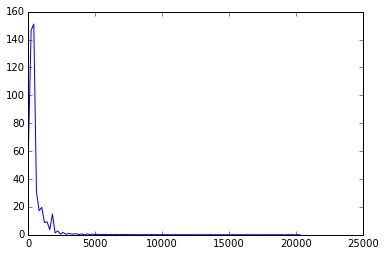

In [219]:
n = len(v1)
if n%2 == 0:
    max_freq = RATE/2.0
else:
    max_freq = RATE/2.0 * (n-1) / n
xs = np.linspace(0, max_freq, n)
ys = np.absolute(v1)
plt.plot(xs, ys)

In [220]:
#voc_s.normalize()

dataout = np.array(voc_s*.05, dtype='int16') #undo the *2 that was done at reading
chunkout = struct.pack("%dh"%(len(dataout)), *list(dataout)) #convert back to 16-bit data
vcs = pygame.sndarray.make_sound(buf)
pygame.mixer.Sound(chunkout).play()

print "done"
print ((voc_s))
print ('convert 1')
print dataout
print "convert 2"
D = len(chunkout)/float(RATE)

done
[ -4.25847972e+01  -4.37084465e+01  -4.43060420e+01 ...,  -3.09608387e-02
  -3.03646975e-02  -2.98610636e-02]
convert 1
[-2 -2 -2 ...,  0  0  0]
convert 2


In [221]:
audio = Audio(data=dataout, rate=RATE)
audio

In [222]:
signal_generated = np.convolve(v_wave.ys,wave.ys)

In [223]:
roar = thinkdsp.Wave(signal_generated,RATE)
roar.make_audio()